Step 1: Set up data and connect to database

In [9]:
from sklearn.metrics.pairwise import rbf_kernel

from src.bookmarks_cluster.db import get_embeddings, db_connect
from src.bookmarks_cluster.embed import EmbeddingSet
import numpy as np

embed_set = EmbeddingSet([], [], [])
with db_connect() as conn:
    for (url, title, embedding) in get_embeddings(conn):
        embed_set.append(url, title, embedding)
assert len(embed_set.urls) == len(embed_set.titles)
assert len(embed_set.titles) == len(embed_set.embeddings)
embeddings = np.stack(embed_set.embeddings)
embeddings.shape

NOTICE:  extension "vector" already exists, skipping
NOTICE:  relation "link_cache" already exists, skipping
NOTICE:  relation "summaries" already exists, skipping
NOTICE:  relation "embeddings" already exists, skipping


(549, 4096)

In [22]:
def _plot3d(dat: np.ndarray):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(range(L.shape[0]), range(L.shape[1]))
    ax.plot_surface(X, Y, dat, cmap='viridis')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(L.shape[0]), range(L.shape[1]))
ax.plot_surface(X, Y, L, cmap='viridis')Step 2: Perform embedding visualization to "gut-check" below results

Text(0.5, 1.0, 't-SNE Visualization of Embeddings')

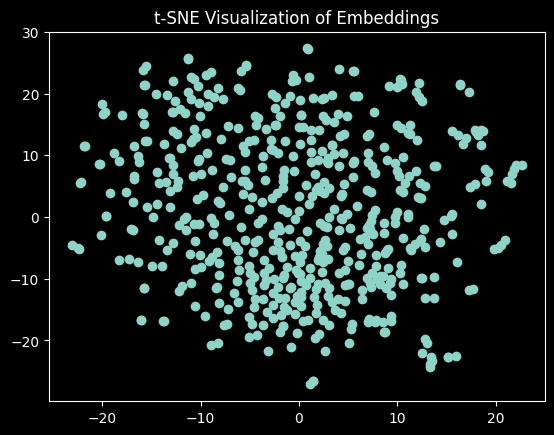

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(embeddings) # Result is shape (N, 2)
plt.scatter(vis_dims[:, 0], vis_dims[:, 1])
plt.title('t-SNE Visualization of Embeddings')

In [15]:
from sklearn.metrics.pairwise import rbf_kernel

rbf = rbf_kernel(embeddings, gamma=0.5)
rbf

array([[1.        , 0.4000508 , 0.401875  , ..., 0.45456988, 0.43349737,
        0.40160558],
       [0.4000508 , 1.        , 0.46684074, ..., 0.46471927, 0.4934584 ,
        0.4115621 ],
       [0.401875  , 0.46684074, 1.        , ..., 0.42710656, 0.48339087,
        0.37383598],
       ...,
       [0.45456988, 0.46471927, 0.42710656, ..., 1.        , 0.5610304 ,
        0.42998344],
       [0.43349737, 0.4934584 , 0.48339087, ..., 0.5610304 , 1.        ,
        0.4196968 ],
       [0.40160558, 0.4115621 , 0.37383598, ..., 0.42998344, 0.4196968 ,
        1.        ]], shape=(549, 549), dtype=float32)

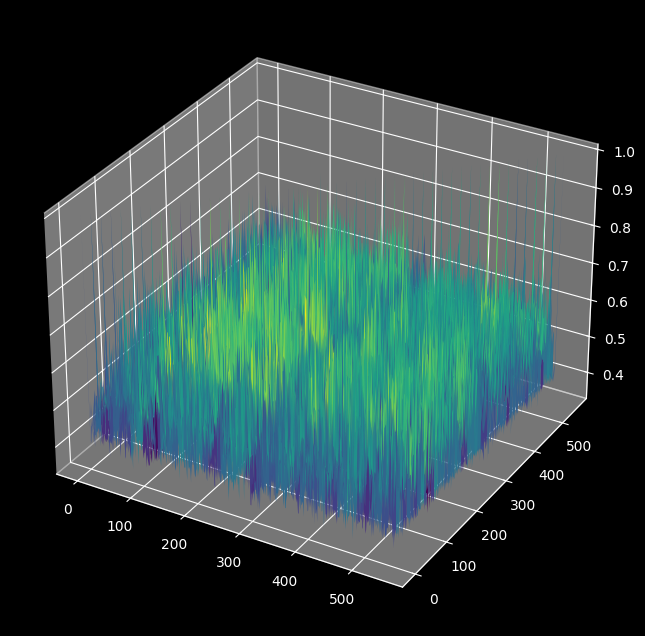

In [25]:
_plot3d(rbf)

In [23]:
from scipy.sparse.csgraph import laplacian

L = laplacian(rbf, normed=True)
L

array([[ 1.        , -0.00165434, -0.0016822 , ..., -0.0017621 ,
        -0.00163883, -0.00175297],
       [-0.00165434,  1.        , -0.00189245, ..., -0.00174456,
        -0.00180661, -0.00173972],
       [-0.0016822 , -0.00189245,  1.        , ..., -0.00162297,
        -0.00179139, -0.00159956],
       ...,
       [-0.0017621 , -0.00174456, -0.00162297, ...,  1.        ,
        -0.00192539, -0.00170378],
       [-0.00163883, -0.00180661, -0.00179139, ..., -0.00192539,
         1.        , -0.00162187],
       [-0.00175297, -0.00173972, -0.00159956, ..., -0.00170378,
        -0.00162187,  1.        ]], shape=(549, 549), dtype=float32)

Plot the laplacian, so I get a feel for it

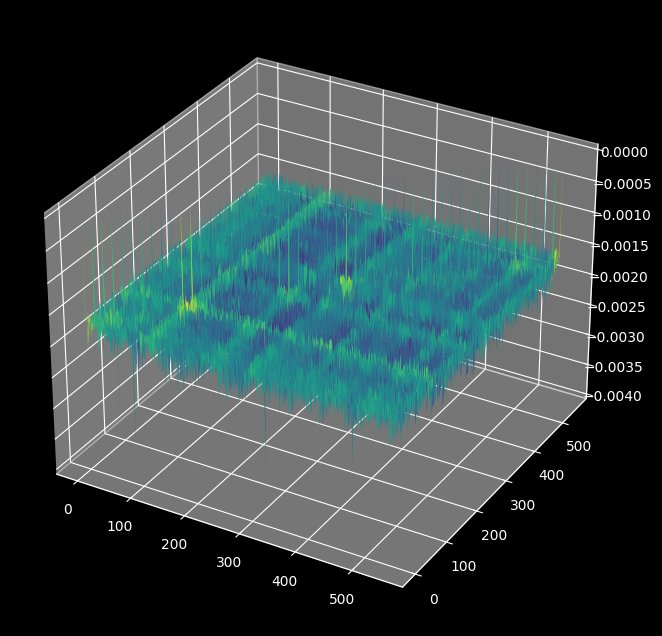

In [28]:
L_no_diag = L.copy()
L_no_diag[np.diag_indices_from(L_no_diag)] = 0 # remove diagonal axis for better visualization
_plot3d(L_no_diag)

In [29]:
from scipy.sparse.linalg import eigsh
eigenvalues, _ = eigsh(L, k=20, which='SM')
eigenvalues

array([3.8372264e-08, 9.3726063e-01, 9.8006785e-01, 9.8452777e-01,
       9.9173814e-01, 9.9261242e-01, 9.9294502e-01, 9.9364293e-01,
       9.9390429e-01, 9.9445003e-01, 9.9481165e-01, 9.9568093e-01,
       9.9595326e-01, 9.9633443e-01, 9.9672276e-01, 9.9675143e-01,
       9.9695885e-01, 9.9743295e-01, 9.9764770e-01, 9.9769855e-01],
      dtype=float32)